In [1]:
import numpy as np
import torch
from pugcn_lib import PUGCN
import os

from tqdm.notebook import tqdm, trange
import open3d as o3d


from train.config import ModelConfig
from utils.data import load_xyz_file
from ChamferDistancePytorch.chamfer3D.dist_chamfer_3D import chamfer_3DDist as ChamferLoss

from utils.viz import viz_many, viz_many_mpl
import matplotlib.pyplot as plt

from omegaconf import OmegaConf


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Jitting Chamfer 3D


/home/zademn/.conda/envs/pytorch_env/lib/python3.9/site-packages/torch/utils/cpp_extension.py:295: UserWarning: 

                               !! WARNING !!

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Your compiler (c++) is not compatible with the compiler Pytorch was
built with for this platform, which is g++ on linux. Please
use g++ to to compile your extension. Alternatively, you may
compile PyTorch from source using c++, and then you can also use
c++ to compile your extension.

See https://github.com/pytorch/pytorch/blob/master/CONTRIBUTING.md for help
with compiling PyTorch from source.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

                              !! WARNING !!

  warnings.warn(WRONG_COMPILER_WARNING.format(


Loaded JIT 3D CUDA chamfer distance


# Load model

Load a model from checkpoint and evaluate with it 

In [2]:
#d = os.listdir(os.path.join("trained-models"))[0]
ckpt_dir = sorted(os.listdir("trained-models"))[-1]

In [3]:
ckpt_name = "ckpt_epoch_10"

In [4]:
checkpoint = torch.load(os.path.join("trained-models", ckpt_dir, ckpt_name))

In [5]:
history = OmegaConf.create(checkpoint["history"])

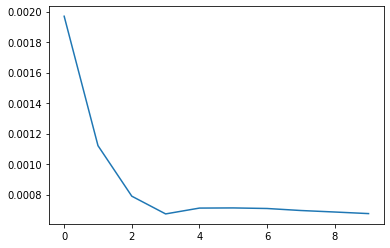

In [6]:
plt.plot(history.train_loss)

In [7]:
model_config = OmegaConf.create(checkpoint["model_config"])

In [8]:
model_config

{'r': 4, 'k': 20, 'dilations': [1, 2], 'n_idgcn_blocks': 2, 'channels': 24, 'n_dgcn_blocks': 3, 'use_bottleneck': True, 'use_pooling': True, 'use_residual': True}

In [9]:
model = PUGCN(
    channels = model_config.channels,
    k = model_config.k,
    r = model_config.r,
    dilations = model_config.dilations,
    n_idgcn_blocks=model_config.n_idgcn_blocks,
    n_dgcn_blocks=model_config.n_dgcn_blocks,
    use_bottleneck = model_config.use_bottleneck,
    use_pooling = model_config.use_pooling,
    use_residual = model_config.use_residual
)
model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

# Qualitative

In [10]:
input_dir = os.path.join("..", "data", "PU1K", "test", "input_256", "input_256")
gt_dir = os.path.join("..", "data", "PU1K", "test", "input_256", "gt_1024")


In [11]:
file = "horse.xyz"
data = load_xyz_file(os.path.join(input_dir, file))
gt = load_xyz_file(os.path.join(gt_dir, file))
data = torch.tensor(data, dtype=torch.float32)
gt = torch.tensor(gt, dtype=torch.float32)

In [12]:
out = model(data).detach()

In [13]:
#o3d
viz_many([data.numpy(), gt.numpy(), out.numpy()]) 

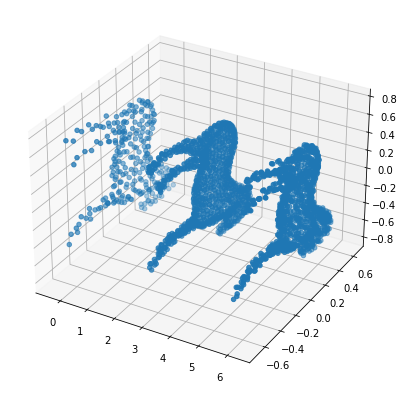

In [27]:
fig = plt.figure(figsize = (7, 7))
ax = plt.axes(projection='3d')
viz_many_mpl([data.numpy(), gt.numpy(), out.numpy()], ax=ax) 

# Quantitative

In [15]:
from utils.losses import hausdorff_loss

In [16]:
chamfer_loss = ChamferLoss()

chamfer_losses = []
hausdorff_losses = []
for file in tqdm(os.listdir(input_dir)):
    # Load files
    data = load_xyz_file(os.path.join(input_dir, file))
    gt = load_xyz_file(os.path.join(gt_dir, file))
    data = torch.tensor(data, dtype=torch.float32)
    gt = torch.tensor(gt, dtype=torch.float32)
    #predict
    out = model(data)
    
    #chamfer
    d1, d2, _, _ = chamfer_loss(out.unsqueeze(0).cuda(), gt.unsqueeze(0).cuda())
    loss = d1.mean() + d2.mean()
    chamfer_losses.append(loss.item())
    
    #hausdorff
    
    loss = hausdorff_loss(out.detach(), gt.detach())
    hausdorff_losses.append(loss)
    

  0%|          | 0/127 [00:00<?, ?it/s]

In [17]:
np.mean(chamfer_losses) * 10**3

4.293425013237875

In [18]:
np.mean(hausdorff_losses) * 10**3

156.74002891974882

In [19]:
t = OmegaConf.create(
    {
        "epochs_trained": checkpoint["epoch"],
        "chamfer_loss": float(np.mean(chamfer_losses) * 10**3),
        "hausdorff_loss": float(np.mean(hausdorff_losses) * 10**3),
        "model_size": checkpoint["model_size"],
    }
)

In [20]:
results = OmegaConf.create()
results.model_config = checkpoint["model_config"]
results.train_config = checkpoint["train_config"]
results.data_config = checkpoint["data_config"]
results.results = t

In [22]:
OmegaConf.save(config=results, f = os.path.join("results", f"results-{ckpt_dir}-{ckpt_name}).yaml"))